# Advanced Time-Series Analysis and Deep Learning: Homework #3

## Motif Discovery

### Mathematical Formulation

(a): In time-series data, motifs are pairs of individual time series, or subsequences of longer time series, which are very similar to each other. A motif can tell us about recurring patterns within time series data!

(b): 
Let me formulate this mathematically. 

Case 1: Time Series Motif

I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

A Time Series Database $D$ is an unordered set of m time series possibly of different lengths.

The Time Series Motif of $D$ is the unordered pair of time series ${T_i, T_j}$ in D which is the most similar among all possible pairs

Essentially, $\forall a,b,i,j$, 

${T_i, T_j}$ is the motif iff $dist(T_i, T_j) ≤ dist(T_a, T_b)$, $i \neq j$ and $a \neq b$.


Case 2: Subsequence Motif

We can also calculate a Subsequence Motif. Given a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 
Let's say we have two subsequences $T_c$ and $T_d$

Essentially, $\forall c,d,i,j$, 

${T_c, T_d}$ is the subsequence motif iff $dist(T_c, T_d) ≤ dist(T_i, T_j)$, $i \neq j$ and $a \neq b$.



### Synthetic Data Generation

In [1]:
import numpy as np

### First Generate sine curve
n = 201

# t => [0, 10 * pi]
t = np.linspace(start = 0, stop = 20 * np.pi, num = n, endpoint = True)
x = np.sin(t)

#Generate Noise
noise = np.random.normal(loc = 0, scale = 2, size = (n,))

#Embed Motif
timestep = 10

for i in range(1, n // timestep, 8):
    pivot = timestep * i
    time_slice = t[pivot - 6 : pivot + 6]
    noise[pivot - 6 : pivot + 6] = np.cos(time_slice)
    print(np.rad2deg(time_slice) % 360, i)

x_adjusted = x + noise

[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 1
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 9
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 17


To generate a synthetic time-series dataset that includes at least one embedded motif, here are the steps I took: 
1. First I generated a normal sine curve. Let's call this x(t)
2. Then, I generated random Gaussian noise with a mean of 0 and a standard deviation of 2. Within this noise curve, I injected a pattern at periodic locations in order to have a recurring motif. Let's call this curve, after the injection of the pattern, n(t)
3. To generate my final curve, I just did x_adjusted(t) = x(t) + n(t)

Text(0.5, 1.0, 'Normal Sine Curve (x(t))')

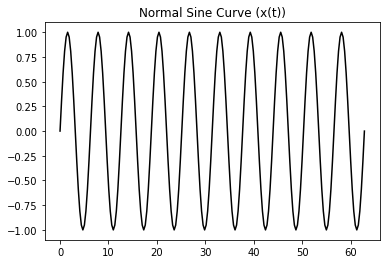

In [2]:
import matplotlib.pyplot as plt
plt.plot(t, x, label='sin(x)', color='black', linestyle='-')
plt.title("Normal Sine Curve (x(t))")

Text(0.5, 1.0, 'Noise with Injected Pattern (n(t))')

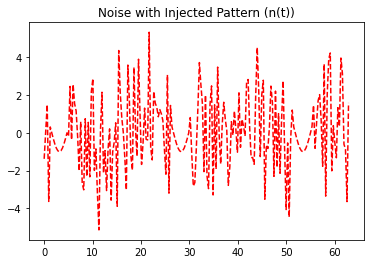

In [3]:
plt.plot(t, noise, label='noise', color='red', linestyle='--')
plt.title("Noise with Injected Pattern (n(t))")

Pivot: 10
Pivot: 90
Pivot: 170


Text(0.5, 1.0, 'Final Plot (x_adjusted(t))')

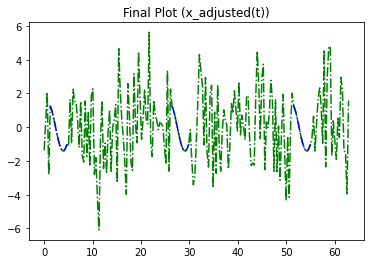

In [4]:
plt.plot(t, x_adjusted, color = 'green', linestyle='-.')  

for i in range(1, n // timestep, 8):
    pivot = timestep * i
    time_slice = t[pivot - 6 : pivot + 6]
    print(f"Pivot: {pivot}")
    plt.plot(time_slice, x_adjusted[pivot - 6 : pivot + 6], color = "blue", linestyle = '-.')

plt.title("Final Plot (x_adjusted(t))")

As you can see in this image, the embedded motif appears(i.e. colored in blue)

## Matrix Profile

General Concept: 
In time series analysis, a matrix profile is used to find anomalies and trends within time series data. 

Mathematical Formulation: 

1. I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

2. A subsequence $T_{i,m}$ of a T is a continuous subset of the values from T of length m starting from position i. $T_{i,m} = t_i, t_{i+1} ,…, t_{i+m-1}$, where $1 \leq i \leq n-m+1$.

3. A distance profile D is a vector of the Euclidean distances between a given query and each subsequence in an all-subsequences set

4. An all-subsequences set A of a time series T is an ordered set of all possible subsequences of T obtained by sliding a window of length m across T: 

$A ={T_{1,m},, T_{2,m},…, T_{n-m+1,m}}$, where m is a user-defined subsequence length. We use A[i] to denote $T_{i,m}$.

5. 1NN-join function: given two all-subsequences sets A and B and two subsequences A[i] and B[j], a 1NN-join function $\theta_{1nn}$ (A[i], B[j]) is a Boolean
function which returns “true” only if B[j] is the nearest neighbor of A[i] in the set B.

6. Similarity join set: given all-subsequences sets A and B, a similarity join set $J_{AB}$ of A and B is a set containing pairs of each subsequence in A with its nearest neighbor in B: $J_{AB}={〈 A[i], B[j] 〉| θ_{1nn} (A[i], B[j])}$ . We denote this formally as $J_{AB} = A \bowtie_{\theta_{1nn}} B$.

7. A matrix profile (or just profile) $P_{AB}$ is a vector of the Euclidean distances between each pair in $J_{AB}$

### Algorithm Implementation

In [5]:
def generate_subsequences_set(T, M):
    N = len(T) - M + 1
    indices = np.arange(M) + np.arange(N)[:, np.newaxis]
    return T[indices]

Given a time series T and a window length M, this function(generate_subsquences_set) creates a list of all contiguous subsequences of length M from the Time Series T

In [6]:
# A: List of contiguous subsequences of length M from the Time Series T
def generate_matrix_profile(A):
    N, M = A.shape[0], A.shape[1]
    
    exclusion = np.ceil(M / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    for i in range(N):
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
        
        min_distance = float('inf')
        min_index = None
        
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = np.linalg.norm(A[i] - A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        distances[i] = min_distance
        indices[i] = min_index
    
    return distances, indices

The input to the function generate_matrix_profile is "A", which represents the list of all contiguous subseequences of length M from the time series T. This function returns two arrays, "distances" and "indices". Let the length of "A" be N. For each index i where 0 $\leq$ i $\leq$ N - 1, distances[i] represents the distance between A[i] and its nearest neighbor and indices[i] = j such that A[j] is the nearest neighbor of A[i]. 

### Matrix Profile Algorithm Implementation

In [7]:
T = x_adjusted
M = 12
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)

#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 4 84]
[84.  4.]
[5.57327535e-15 5.57327535e-15]


In [8]:
pivot = timestep * 1
time_period = t[pivot - 6 : pivot + 6]
print(f"Times: {time_period}")
print("----------------------------------------------------------------------------------------")
print(f"Motif Values: {np.sin(time_period) + np.cos(time_period)}")
print("----------------------------------------------------------------------------------------")

print(f"Motif Values detected by Matrix Profile Algorithm: {A[ix]}")


Times: [1.25663706 1.57079633 1.88495559 2.19911486 2.51327412 2.82743339
 3.14159265 3.45575192 3.76991118 4.08407045 4.39822972 4.71238898]
----------------------------------------------------------------------------------------
Motif Values: [ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
 -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]
----------------------------------------------------------------------------------------
Motif Values detected by Matrix Profile Algorithm: [[ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
  -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]
 [ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
  -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]]


As shown by this print output, when we found the subsequences with the minimum distance to its nearest neighbor(i.e. nearest subsequenc of the time series by Euclidean Distance), we can see that it matches the Motif Values!

### Optimized Matrix Profile Algorithm Implementation

In [9]:
### Optimize Matrix Profile Algorithm using FFT Approach outlined in paper
def sliding_dot_product(Q, T):
    n, m = len(T), len(Q)
    Ta = np.append(T, np.zeros(n))
    Qr = np.flip(Q)
    Qra = np.append(Qr, np.zeros(2 * n - m))
    Qraf, Taf = np.fft.fft(Qra), np.fft.fft(Ta)
    QT = np.fft.ifft(Qraf * Taf)
    return QT

def compute_mean_std(Q, T):
    uq = np.mean(Q)
    stdev_Q = np.std(Q)
    n,m = len(T), len(Q)
    
    M = np.zeros(shape = (n - m + 1,))
    Sigma = np.zeros(shape = (n - m + 1,))
    window = T[0:m]
    
    M[0] = np.mean(window)
    Sigma[0] = np.std(window)
    
    total = np.sum(window)
    total_elements_squared = np.sum(window ** 2)
    
    window_start = 0
    window_end = m - 1
    
    for index in range(1, n - m + 1):
        total = total - T[window_start] + T[window_end + 1]
        total_elements_squared = total_elements_squared - (T[window_start] ** 2) + (T[window_end + 1] ** 2)
        
        M[index] = total / m
        Sigma[index] = np.sqrt((total_elements_squared - (2 * M[index] * total) + ((M[index] ** 2) * m)) / m)
        
        window_start += 1
        window_end += 1
    
    return uq, stdev_Q, M, Sigma

def calculate_distance_profile(Q, T, QT, uq, stdev_Q, MT, SigmaT):
    n, m = len(T), len(Q)
    QT = QT[m - 1: n]
    
    D = np.sqrt(2 * m * (1 - ((QT - m * uq * MT) / (m * stdev_Q * SigmaT))))
    return D

def MASS(Q, T):
    QT = sliding_dot_product(Q, T)
    uq, stdev_Q, MT, SigmaT = compute_mean_std(Q, T)
    D = calculate_distance_profile(Q, T, QT, uq, stdev_Q, MT, SigmaT)
    return D

def optimized_matrix_profile(A):
    N, M = A.shape[0], A.shape[1]
    exclusion = np.ceil(M / 2)
    
    distance_profile = np.zeros(shape = (len(A),))
    index_profile = np.zeros(shape = (len(A),))
    
    for index in range(len(A)):
        row = A[index]
        distances = MASS(row, T)
        
        bound1 = max(0, index - exclusion)
        bound2 = min(index + exclusion, N - 1)
        distances[int(bound1): int(bound2) + 1] = np.inf
        
        distance_profile[index] = np.min(distances)
        index_profile[index] = np.argmin(distances)
    
    return distance_profile, index_profile

This is an implementation of the STAMP Algorithm outlined in the paper "Matrix Profile I: All Pairs Similarity Joins for Time Series: A Unifying View that Includes Motifs, Discords and Shapelets". This algorithm relies on FFT(Fast Fourier Transform) to compute Euclidean distances between a subsequence and subsequences in the original time sries. 

### Testing Optimized Matrix Profile Algorithm Implementation

In [10]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = optimized_matrix_profile(A)

#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_38076/2214664726.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  distance_profile[index] = np.min(distances)


[164]
[84.]
[3.03213663e-10]


In [11]:
pivot = timestep * 1
time_period = t[pivot - 6 : pivot + 6]
print(f"Times: {time_period}")
print("----------------------------------------------------------------------------------------")
print(f"Motif Values: {np.sin(time_period) + np.cos(time_period)}")
print("----------------------------------------------------------------------------------------")

print(f"Motif Value detected by Optimized Matrix Profile Algorithm: {A[ix]}")


Times: [1.25663706 1.57079633 1.88495559 2.19911486 2.51327412 2.82743339
 3.14159265 3.45575192 3.76991118 4.08407045 4.39822972 4.71238898]
----------------------------------------------------------------------------------------
Motif Values: [ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
 -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]
----------------------------------------------------------------------------------------
Motif Value detected by Optimized Matrix Profile Algorithm: [[ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
  -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]]


As shown by this print output, when we found the subsequences with the minimum distance to its nearest neighbor(i.e. nearest subsequenc of the time series by Euclidean Distance), we can see that it matches the Motif Values!

### Testing Optimized Matrix Profile Algorithm Implementation On Other Synthetic Data

In [12]:
## Generate Other Synthetic Data
import numpy as np

### First Generate sine curve
n_optimized = 201

# t => [0, 10 * pi]
t_optimized = np.linspace(start = 0, stop = 20 * np.pi, num = n_optimized, endpoint = True)
x_optimized = np.sin(t_optimized) * 2 + np.cos(t_optimized) * 3

#Generate Noise
noise_optimized = np.random.normal(loc = 0, scale = 3, size = (n_optimized,))

#Embed Motif
timestep = 10

for i in range(1, n_optimized // timestep, 8):
    pivot = timestep * i
    time_slice = t_optimized[pivot - 6 : pivot + 6]
    noise_optimized[pivot - 6 : pivot + 6] = np.cos(time_slice) ** 2
    print(np.rad2deg(time_slice) % 360, i)

x_adjusted_optimized = x_optimized + noise_optimized

[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 1
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 9
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 17


Text(0.5, 1.0, 'Normal Curve (x_optimized(t))')

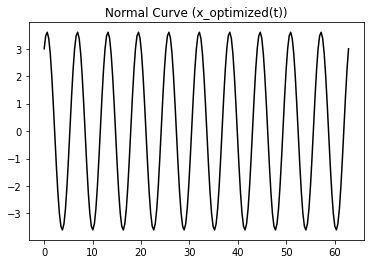

In [13]:
import matplotlib.pyplot as plt
plt.plot(t_optimized, x_optimized, label='sin(x)', color='black', linestyle='-')
plt.title("Normal Curve (x_optimized(t))")

Text(0.5, 1.0, 'Noise with Injected Pattern (n_optimized(t))')

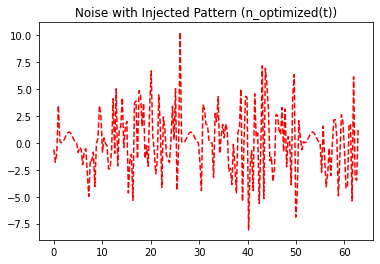

In [14]:
plt.plot(t_optimized, noise_optimized, label='noise', color='red', linestyle='--')
plt.title("Noise with Injected Pattern (n_optimized(t))")

Pivot: 10
[ 2.92465552  2.          1.07055355  0.20016973 -0.59697198 -1.33062706
 -2.         -2.56669504 -2.94811299 -3.03589824 -2.73367251 -2.        ]
Pivot: 90
[ 2.92465552  2.          1.07055355  0.20016973 -0.59697198 -1.33062706
 -2.         -2.56669504 -2.94811299 -3.03589824 -2.73367251 -2.        ]
Pivot: 170
[ 2.92465552  2.          1.07055355  0.20016973 -0.59697198 -1.33062706
 -2.         -2.56669504 -2.94811299 -3.03589824 -2.73367251 -2.        ]


Text(0.5, 1.0, 'Final Plot (x_adjusted_optimized(t))')

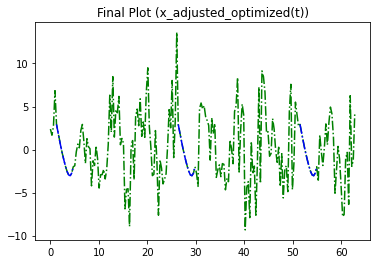

In [15]:
plt.plot(t_optimized, x_adjusted_optimized, color = 'green', linestyle='-.')  

for i in range(1, n // timestep, 8):
    pivot = timestep * i
    time_slice = t_optimized[pivot - 6 : pivot + 6]
    print(f"Pivot: {pivot}")
    print(x_adjusted_optimized[pivot - 6 : pivot + 6])
    plt.plot(time_slice, x_adjusted_optimized[pivot - 6 : pivot + 6], color = "blue", linestyle = '-.')

plt.title("Final Plot (x_adjusted_optimized(t))")

In [16]:
T_optimized = x_adjusted_optimized
M_optimized = 12
A_optimized = generate_subsequences_set(T_optimized, M_optimized)
distance_profile_optimized, index_profile_optimized = optimized_matrix_profile(A_optimized)

#To find a motif, we need to find a minimum value in the distance profile 
ix_optimized = np.where(distance_profile_optimized == np.min(distance_profile_optimized))[0]

index_profile_ix_optimized = index_profile_optimized[ix_optimized]
distance_profile_ix_optimized = distance_profile_optimized[ix_optimized]

print(ix_optimized)
print(index_profile_ix_optimized)
print(distance_profile_ix_optimized)

[  4 164]
[84. 84.]
[0.27178622 0.27178622]


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_38076/2214664726.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  distance_profile[index] = np.min(distances)


In [17]:
pivot = timestep * 1
time_period_optimized = t_optimized[pivot - 6 : pivot + 6]
print(f"Times: {time_period_optimized}")
print("----------------------------------------------------------------------------------------")
print(f"Motif Values: {np.sin(time_period_optimized) * 2 + np.cos(time_period_optimized) * 3 + np.cos(time_period_optimized) ** 2}")
print("----------------------------------------------------------------------------------------")

print(f"Motif Subsequence detected by Optimized Matrix Profile Algorithm: {A_optimized[ix_optimized]}")


Times: [1.25663706 1.57079633 1.88495559 2.19911486 2.51327412 2.82743339
 3.14159265 3.45575192 3.76991118 4.08407045 4.39822972 4.71238898]
----------------------------------------------------------------------------------------
Motif Values: [ 2.92465552  2.          1.07055355  0.20016973 -0.59697198 -1.33062706
 -2.         -2.56669504 -2.94811299 -3.03589824 -2.73367251 -2.        ]
----------------------------------------------------------------------------------------
Motif Subsequence detected by Optimized Matrix Profile Algorithm: [[ 2.92465552  2.          1.07055355  0.20016973 -0.59697198 -1.33062706
  -2.         -2.56669504 -2.94811299 -3.03589824 -2.73367251 -2.        ]
 [ 2.92465552  2.          1.07055355  0.20016973 -0.59697198 -1.33062706
  -2.         -2.56669504 -2.94811299 -3.03589824 -2.73367251 -2.        ]]


As shown by this print output, when we found the subsequences with the minimum distance to its nearest neighbor(i.e. nearest subsequenc of the time series by Euclidean Distance), we can see that it matches the Motif Values!

## Discord Identification

1. Time series discords are subsequences of longer time series that are maximally different to the rest of the time series subsequences. 

Mathematical Formulation: 

- I will define a time series $T$ where $T = [t_1, t_2, ...., t_m ]$ consists of a set of $m$ real numbers. 

- We can define a subsequence $C$ of length $n$, where $n \leq m$, which is a contiguous slice from $T$. 

$C = [t_p, t_{p + 1}, ...., t_{p+n-1}]$ for $1 \leq p \leq m - n + 1$

- Given two subsequences, $C$ and $B$, we can define a function $D$ such that $D(B, C) = R$ where $R$ is a non-negative number and represents the distance between $B$ and $C$. 

- Non-Self Match: : Given a time series T, containing a subsequence C of length n beginning at position p and a matching subsequence B beginning at q, we say that B is a non-self match to C at distance of $D(B, C)$ if $|p - q| \geq n$

- Time Series Discord: Given a time series T, the subsequence A of length n beginning at position $i$ is said to be the discord of T if A has the largest distance to its nearest non-self match. $\forall C \in T$, let $M_C$ be any arbitrary non-self match of $C$ and $M_A$ be any arbitrary non-self match of $A$. We want the following to be true: 

$min(D(A, M_D)) > min(D(C, M_C))$


### Implementation of Discord Identification Algorithm

To identify discords within a time series, this is the procedure I followed: 
1. First I generated the matrix profile as normally. 
2. A discord is the subsequence within the time series with the largest entry in the distance profile. To recap, the distance profile array basically denotes, for each contiguous subsequence within the time series, the distance to its closest neighbor. Hence, we can see that the subsequence with the largest entry in the distance profile has the largest distance to its nearest neighbor. This indicates that this subsequence is somewhat "anomalous" with respect to the entire time series. 

In [18]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)

#To find a Discord, we need to find a maximum value in the distance profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

Again, as I mentioned earlier, the discord is basically the subsequence within the time series with the largest entry in the distance profile. The code above is responsible for finding this subsequence

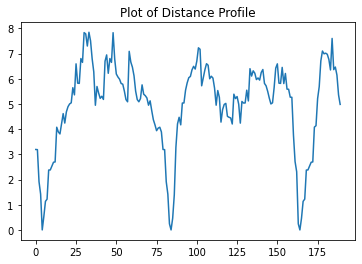

In [19]:
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.title("Plot of Distance Profile")
plt.show()

The above plot is a plot of the distance profile

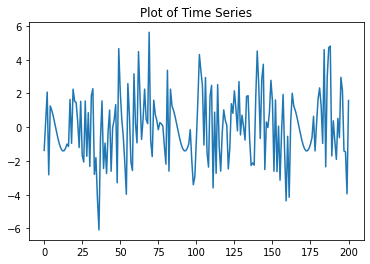

In [20]:
plt.plot(T)
plt.title("Plot of Time Series")
plt.show()

This is a plot of the time series

In [21]:
A[ix]

array([[-2.79582234, -1.80091691, -4.22848441, -6.08528589, -0.67784973,
         1.55824103, -2.44315842, -0.94088936, -2.74466287, -0.26570951,
         1.01684009, -2.60842342]])

The above vector is the subsequence that represents the discord for this time series!

### HOT SAX Algorithm

In [22]:
#Define Gaussian Distribution
mean = np.mean(T) #mean of time series
var = np.var(T) #variance of time series
stdev = np.std(T) #standard deviation of time series

#Given a window, return a letter to represent that window. 
def discretize_window(window):
    u = np.mean(window)
    if u <= mean - 2.2 * stdev:
        return 'A'
    elif u <= mean - 2.0 * stdev:
        return 'B'
    elif u <= mean - 1.8 * stdev:
        return 'C'
    elif u <= mean - 1.6 * stdev:
        return 'D'
    elif u <= mean - 1.4 * stdev:
        return 'E'
    elif u <= mean - 1.2 * stdev:
        return 'F'
    elif u <= mean - 1.0 * stdev:
        return 'G'
    elif u <= mean - 0.8 * stdev:
        return 'H'
    elif u <= mean - 0.6 * stdev:
        return 'I'
    elif u <= mean - 0.4 * stdev:
        return 'J'
    elif u <= mean - 0.2 * stdev:
        return 'K'
    elif u <= mean:
        return 'L'
    elif u <= mean + 0.2 * stdev:
        return 'M'
    elif u <= mean + 0.4 * stdev:
        return 'N'
    elif u <= mean + 0.6 * stdev:
        return 'O'
    elif u <= mean + 0.8 * stdev:
        return 'P'
    elif u <= mean + 1.0 * stdev:
        return 'Q'
    elif u <= mean + 1.2 * stdev:
        return 'R'
    elif u <= mean + 1.4 * stdev:
        return 'S'
    elif u <= mean + 1.6 * stdev:
        return 'T'
    elif u <= mean + 1.8 * stdev:
        return 'U'
    elif u <= mean + 2.0 * stdev:
        return 'V'
    elif u <= mean + 2.2 * stdev:
        return 'W'
    else:
        return 'X'

#Generate letter sequence for a time series. 
#T: original time series
#P: window of time series used to generate a letter
def generate_word(T, P):
    return np.apply_along_axis(discretize_window, axis = 1, arr = generate_subsequences_set(T, P)).flatten()

#Given two words, calculate the edit distance between the two words. 
#A word is defined as a sequence of letters
#W1 and W2 are the two words
def edit_distance(W1, W2):
    if len(W2) == 0:
        return len(W1)

    if len(W1) == 0:
        return len(W2)
    
    if W1[0] == W2[0]:
        return edit_distance(W1[1:], W2[1:])
    
    return 1 + min(edit_distance(W1[1:], W2), edit_distance(W1, W2[1:]), edit_distance(W1[1:], W2[1:]))

M = 12
P = 3

#Generate word for the time series 
W = generate_word(T, P)

L = M // P #letter subsequence length

#Generate subsequence of words
A = generate_subsequences_set(W, L)

#Calculate matrix profile for the word subsequences
#The steps are roughly identical to the matrix profile algorithm that was previously implemented
def generate_SAX_matrix_profile(A):
    N, L = A.shape[0], A.shape[1]
    
    exclusion = np.ceil(L / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    for i in range(N):
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
                
        min_distance = float('inf')
        min_index = None
        
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = edit_distance(A[i], A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        distances[i] = min_distance
        indices[i] = min_index
    
    return distances, indices

When calculating the matrix profile for HOT SAX, it is the same steps I followed earlier for the regular matrix profile but this time, we are using letter sequences.

In [23]:
#To find a motif, we need to find a minimum value in the distance profile 
distance_profile, index_profile = generate_SAX_matrix_profile(A)
ix = np.where(distance_profile == np.min(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[  4   5   6   7   8   9  10  11  12  23  41  72  83  84  85  86  87  88
  89  90 128 163 164 165 166 167 168 169 170 171 172 189]
[ 84.  85.  86.  87.  88.  89.  90. 171. 172.  41.  23. 128. 163.   4.
   5.   6.   7.   8.   9.  10.  72.  83.   4.   5.   6.   7.   8.   9.
  10.  11.  12.  23.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
#Print the Motif
A[ix]

array([['O', 'N', 'M', 'L'],
       ['N', 'M', 'L', 'K'],
       ['M', 'L', 'K', 'J'],
       ['L', 'K', 'J', 'J'],
       ['K', 'J', 'J', 'I'],
       ['J', 'J', 'I', 'I'],
       ['J', 'I', 'I', 'J'],
       ['I', 'I', 'J', 'J'],
       ['I', 'J', 'J', 'L'],
       ['K', 'K', 'K', 'K'],
       ['K', 'K', 'K', 'K'],
       ['O', 'M', 'M', 'M'],
       ['P', 'O', 'N', 'M'],
       ['O', 'N', 'M', 'L'],
       ['N', 'M', 'L', 'K'],
       ['M', 'L', 'K', 'J'],
       ['L', 'K', 'J', 'J'],
       ['K', 'J', 'J', 'I'],
       ['J', 'J', 'I', 'I'],
       ['J', 'I', 'I', 'J'],
       ['O', 'M', 'M', 'M'],
       ['P', 'O', 'N', 'M'],
       ['O', 'N', 'M', 'L'],
       ['N', 'M', 'L', 'K'],
       ['M', 'L', 'K', 'J'],
       ['L', 'K', 'J', 'J'],
       ['K', 'J', 'J', 'I'],
       ['J', 'J', 'I', 'I'],
       ['J', 'I', 'I', 'J'],
       ['I', 'I', 'J', 'J'],
       ['I', 'J', 'J', 'L'],
       ['K', 'K', 'K', 'K']], dtype='<U1')

For the motif, HOT SAX returned a bunch of subsequences. It wasn't as effective, based on my experiments, as the sliding window approach I implemented earlier for matrix profiles. 

In [25]:
#To find a Discord, we need to find a Maximum value in the distance profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 32  33  34  95  96  97  99 137 156 157 186]
[ 8. 93.  5.  9.  5.  6.  8.  9.  0.  8.  2.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [26]:
#Print the Discord
A[ix]

array([['K', 'E', 'C', 'D'],
       ['E', 'C', 'D', 'H'],
       ['C', 'D', 'H', 'K'],
       ['J', 'H', 'F', 'G'],
       ['H', 'F', 'G', 'K'],
       ['F', 'G', 'K', 'Q'],
       ['K', 'Q', 'T', 'U'],
       ['J', 'P', 'T', 'R'],
       ['M', 'I', 'G', 'E'],
       ['I', 'G', 'E', 'I'],
       ['W', 'S', 'O', 'K']], dtype='<U1')

For the discord, HOT SAX returned a bunch of subsequences. It wasn't as effective, based on my experiments, as the sliding window approach I implemented earlier for matrix profiles. 

### Running Discord Identification on Real World Multivariate Dataset

In [27]:
import pandas as pd

## Load a Multivariate Time Series Dataset
delhi_train = pd.read_csv("DailyDelhiClimateTrain.csv")
delhi_test = pd.read_csv("DailyDelhiClimateTest.csv")

In [28]:
#Convert the delhi training dataframe to matrix. We don't need to include the date in our matrix!
T = delhi_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12

In [29]:
#Compute Matrix Profile
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)
distance_profile, index_profile

(array([36.02482202, 39.82550022, 38.36494455, ..., 41.48702351,
        40.19443415, 38.54110535]),
 array([  15., 1082., 1083., ...,    7.,  412.,  413.]))

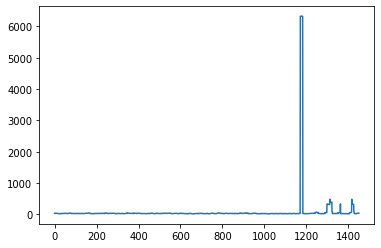

In [30]:
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.show()

As shown by the figure, the subsequence with index 1182 has the largest distance to its nearest neighbor. Hence, it clearly must be a discord!

In [31]:
#To find a Discord, we need to find a Maximum value in the distance profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[1182]
[1362.]
[6327.31370352]


Our algorithm, as per the "ix" variable, was able to identify the subsequence with index 1182 as the discord!

In [32]:
#Print Discord
A[ix]

array([[[2.59333333e+01, 5.28000000e+01, 6.54666667e+00, 7.67933333e+03],
        [2.71250000e+01, 4.77500000e+01, 7.29375000e+00, 1.01131250e+03],
        [2.95714286e+01, 3.97857143e+01, 7.02142857e+00, 1.01114286e+03],
        [3.00000000e+01, 3.97333333e+01, 4.33333333e+00, 1.00920000e+03],
        [3.05714286e+01, 3.82142857e+01, 1.20357143e+01, 1.00671429e+03],
        [3.23125000e+01, 3.85625000e+01, 5.46250000e+00, 1.00800000e+03],
        [3.33125000e+01, 4.42500000e+01, 2.55000000e+00, 1.00837500e+03],
        [3.28125000e+01, 3.31250000e+01, 8.00000000e+00, 1.00668750e+03],
        [3.23125000e+01, 2.93125000e+01, 9.26875000e+00, 1.00700000e+03],
        [3.13750000e+01, 3.31250000e+01, 3.47500000e+00, 1.00687500e+03],
        [2.99333333e+01, 3.70000000e+01, 1.08500000e+01, 1.00726667e+03],
        [2.92666667e+01, 3.60000000e+01, 4.68666667e+00, 1.00920000e+03]]])

# Deep Neural Network

Implement a Deep Neural Network from scratch for a simple classification problem, excluding the backpropagation algorithm. [20 points]

In [33]:
import numpy as np

class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1, self.b1, self.W2, self.b2 = self.initialize_parameters()

    def initialize_parameters(self):
        # Initialize weights and biases
        # TODO: Initialize W1, b1, W2, and b2
        
        #Shape of W1: (hidden_dim, input_dim)
        W1 = np.random.randn(self.hidden_dim, self.input_dim) * np.sqrt(1 / (self.input_dim + self.hidden_dim))
        
        #Shape of b1: (hidden_dim)
        b1 = np.random.randn(self.hidden_dim, 1) * np.sqrt(1 / (self.input_dim + self.hidden_dim))
        
        #Shape of W2: (output_dim, hidden_dim)
        W2 = np.random.randn(self.output_dim, self.hidden_dim) * np.sqrt(1 / (self.hidden_dim + self.output_dim))
        
        #Shape of b2: (output_dim)
        b2 = np.random.randn(self.output_dim, 1) * np.sqrt(1 / (self.hidden_dim + self.output_dim))
        
        return W1, b1, W2, b2

    def sigmoid(self, Z):
        # Sigmoid activation function
        # TODO: Implement sigmoid activation
        return 1 / (1 + np.exp(-1 * Z))

    def forward_propagation(self, X):
        # Forward propagation
        # TODO: Implement forward propagation
        
        Z1 = self.W1 @ X + np.tile(self.b1, reps = (1, X.shape[1]))
        A1 = self.sigmoid(Z1)
        
        Z2 = self.W2 @ A1 + np.tile(self.b2, reps = (1, A1.shape[1]))
        A2 = self.sigmoid(Z2)
        
        return Z1, A1, Z2, A2

    def compute_cost(self, A2, Y):
        # Compute the cost
        # TODO: Implement cost computation
        
        #Clip values to avoid log(0) :) 
        epsilon = 1e-20
        A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
        
        loss = - (Y * np.log(A2_clipped) + (1 - Y) * np.log(1 - A2_clipped))
        average_loss = np.mean(loss)
        
        return average_loss

    def backpropagation(self, X, Y, Z1, A1, Z2, A2):
        grads = {}
        m = X.shape[1]

        # Compute gradients
        dZ2 = A2 - Y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.dot(self.W2.T, dZ2) * (A1 * (1 - A1))
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        return grads

    def update_parameters(self, grads, learning_rate):
        # Update weights and biases
        self.W1 -= learning_rate * grads['dW1']
        self.b1 -= learning_rate * grads['db1']
        self.W2 -= learning_rate * grads['dW2']
        self.b2 -= learning_rate * grads['db2']


    def train(self, X, Y, learning_rate, num_iterations):
        for i in range(num_iterations):
            Z1, A1, Z2, A2 = self.forward_propagation(X)
            cost = self.compute_cost(A2, Y)
            grads = self.backpropagation(X, Y, Z1, A1, Z2, A2)
            self.update_parameters(grads, learning_rate)
            if i % 100 == 0:
                print(f"Iteration {i}, Cost: {cost}")

if __name__ == "__main__":
    # Generate synthetic data
    X = np.random.rand(2, 500)
    Y = np.random.randint(0, 2, size=(1, 500))

    # Initialize the neural network
    nn = SimpleNN(2, 4, 1)

    # Train the neural network
    nn.train(X, Y, learning_rate=0.01, num_iterations=1000)

Iteration 0, Cost: 0.816958311125785
Iteration 100, Cost: 0.7435608952535575
Iteration 200, Cost: 0.7125649702040519
Iteration 300, Cost: 0.7002469849555268
Iteration 400, Cost: 0.695488622803018
Iteration 500, Cost: 0.6936732667715249
Iteration 600, Cost: 0.6929839147633882
Iteration 700, Cost: 0.6927219933480464
Iteration 800, Cost: 0.6926217251075354
Iteration 900, Cost: 0.6925824840827284


# Convolutional Neural Network

Complete the convolution code below. [10 points]

In [34]:
import numpy as np

def convolution2D(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate the output dimensions
    output_height = image_height - kernel_height + 1
    #TODO: Compute the output height
    output_width = image_width - kernel_width + 1
    #TODO: Compute the output width
    
    # Initialize the output feature map
    output = np.zeros((output_height, output_width))
    
    # Perform 2D convolution
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest (ROI) from the image
            #todo: Extract the region of interest (ROI) from the image
            
            ROI = image[i:i+kernel_height, j:j+kernel_width]
            
            # Compute the element-wise multiplication and sum
            #todo: Compute the element-wise multiplication and sum
            output[i][j] = np.sum(ROI * kernel)
    
    return output

# Example usage:
if __name__ == "__main__":
    # Create a sample grayscale image (8x8 pixels)
    image = np.array([[1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1]])
    
    # Create a sample kernel (3x3)
    kernel = np.array([[1, 0, -1],
                       [1, 0, -1],
                       [1, 0, -1]])
    
    # Perform 2D convolution
    result = convolution2D(image, kernel)
    print(result)

[[-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]]


# Integrated Application

Implement an end-to-end pipeline for automated time series classification that inte- grates motif and discord detection with deep learning. [10 Bonus Points]

In [35]:
import pandas as pd

## Load a Multivariate Time Series Dataset
delhi_train = pd.read_csv("DailyDelhiClimateTrain.csv") #training data
delhi_test = pd.read_csv("DailyDelhiClimateTest.csv") #test data

In [36]:
delhi_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [37]:
delhi_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [38]:
## Use the matrix profile and HOT SAX algorithms to identify motifs and discords in the time series data. These can help discover salient patterns and anomalies.

## This will be done on the training data

#Convert the delhi training dataframe to matrix. We don't need to include the date in our matrix!
T = delhi_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12

In [39]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)
distance_profile, index_profile

(array([36.02482202, 39.82550022, 38.36494455, ..., 41.48702351,
        40.19443415, 38.54110535]),
 array([  15., 1082., 1083., ...,    7.,  412.,  413.]))

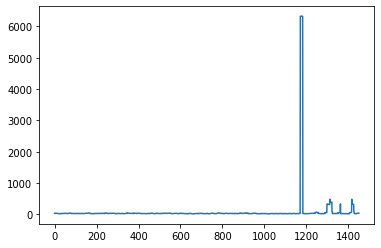

In [40]:
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.show()

In [41]:
#Let's put the distance profiles on a distribution in order to calculate labels. 
#If the absolute value of the z score is < 2, then we will say that the subsequence is "anomalous"
u = np.mean(distance_profile)
std = np.std(distance_profile)
z_scores = np.array([(x - u) / std for x in distance_profile])
labels = np.array([1 if np.abs(z_score) < 2 else 0 for z_score in z_scores])

In [42]:
### Define a 1D Convolutional Neural Network via PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self, input_length, in_channels, num_filters, kernel_size, pool_kernel_size, output_fc_1, output_fc_2):
        super().__init__()
        
        #Define Structure of CNN
        self.L = input_length
        self.K = kernel_size
        self.P = pool_kernel_size
        self.Cin = in_channels
        self.Cout = num_filters
        
        self.output_fc_1 = output_fc_1
        self.output_fc_2 = output_fc_2
        
        #1D Convolution
        self.conv = nn.Conv1d(in_channels = self.Cin, out_channels = self.Cout, kernel_size = self.K)
        
        #Pooling Layer
        self.pool = nn.MaxPool1d(self.P)
        
        conv_L = self.L - self.K + 1

        # Fully connected layer
        self.fc1 = nn.Linear((int(0.5 * (conv_L - self.P)) + 1) * self.Cout, self.output_fc_1)
        self.fc2 = nn.Linear(self.output_fc_1, self.output_fc_2)
        
        #Sigmoid Function
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        #Start with Convolution and Pooling Layers
        x = self.conv(input)        
        x = self.pool(x)
        
        #Run through fully connected layers
        x = torch.flatten(x, 1)                
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        #Run through sigmoid
        x = self.sigmoid(x)      
        return torch.flatten(x)

In [43]:
import torch.optim as optim
def train(model, input, labels, epochs):
    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
    loss_fn = nn.BCELoss(reduction = 'mean')
    for epoch in range(epochs):        
        #Zero out gradients
        optimizer.zero_grad()
        
        #Run Forward Pass, Backward Propagation, then update weights
        outputs = model(input)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #Pring Loss        
        print(f'[Epoch {epoch + 1}] loss: {loss.item():.3f}')

In [44]:
shape = A.shape
model = CNN1D(shape[1], shape[2], 3, 3, 2, 6, 1).to(torch.float32)

A = torch.permute(torch.from_numpy(A), (0, 2, 1)).to(torch.float32)
labels = torch.from_numpy(labels).to(torch.float32)

print(A.size())
print(labels.size())

torch.Size([1451, 4, 12])
torch.Size([1451])


In [45]:
train(model, A, labels, 10)

[Epoch 1] loss: 0.555
[Epoch 2] loss: 0.554
[Epoch 3] loss: 0.554
[Epoch 4] loss: 0.554
[Epoch 5] loss: 0.554
[Epoch 6] loss: 0.554
[Epoch 7] loss: 0.553
[Epoch 8] loss: 0.553
[Epoch 9] loss: 0.553
[Epoch 10] loss: 0.553


In [46]:
T2 = delhi_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12
A = generate_subsequences_set(T, M)
A2 = generate_subsequences_set(T2, M)

#For the test data set, we need to calculate distances to the training data subsequences. 
distance_profile = np.zeros(shape = len(A2,))
for index in range(len(A2)):
    norms = np.linalg.norm(A2[index] - A, axis = (1,2)).flatten()
    distance_profile[index] = np.min(norms)

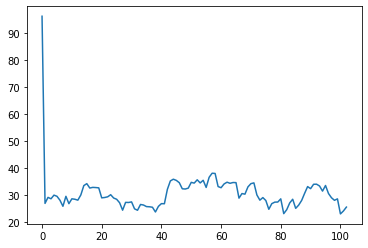

In [47]:
#Plot distance profile
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.show()

In [48]:
#Let's put the distance profiles on a distribution in order to calculate labels
#If the absolute value of the z score is < 2, then we will say that the subsequence is "anomalous"
u = np.mean(distance_profile)
std = np.std(distance_profile)
z_scores = np.array([(x - u) / std for x in distance_profile])
labels = np.array([1 if np.abs(z_score) < 2 else 0 for z_score in z_scores])

In [49]:
A2 = torch.permute(torch.from_numpy(A2), (0, 2, 1)).to(torch.float32)
labels = torch.from_numpy(labels).to(torch.float32)

In [50]:
correct = 0
total = 0
loss_fn = nn.BCELoss(reduction = 'mean') #Binary Cross Entropy Loss Function

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    # calculate outputs by running input through the network
    outputs = model(A2)
    predictions = (outputs >= 0.5).int().to(torch.float32)
    loss = loss_fn(outputs, labels)
    total += labels.size(0)
    correct += (predictions == labels).sum().item()
    print(f"Binary Cross Entropy Loss: {loss}")

print(f'Accuracy of the Model on the {total} Test Subsequences: {100 * correct // total} %')

Binary Cross Entropy Loss: 0.9708737730979919
Accuracy of the Model on the 103 Test Subsequences: 99 %
